In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import pandas as pd
import numpy as np
import re
import keras
from tqdm import tqdm
import pickle as pkl
import gc
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers
import tensorflow as tf
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
import multiprocessing
import os
gc.enable()

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, TimeDistributed, Activation, Masking, Input
from tensorflow.keras.layers import LSTM, Bidirectional, dot, concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import * 
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.backend import squeeze
from tensorflow.keras. optimizers import RMSprop, Adam

import xgboost as xgb
import statsmodels.api as sm
import pylab as plt
from scipy import stats

%pylab inline

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7111740521393919300
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15120729688407102860
physical_device_desc: "device: XLA_CPU device"
]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



## Обучаем LSTM в такой парадигме: Предсказываем следующий элемент в последовательности

In [ ]:
order_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/order_features.csv')
order_features['prod_seq'] = order_features['prod_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))
order_features['prev_seq'] = order_features['prev_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))
order_features['prev_orders_seq'] = order_features['prev_orders_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))

train_positive = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_positive.csv')
train_negative = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_negative.csv')

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/id_to_token.pkl', 'rb') as f:
  id_to_token = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/token_to_id.pkl', 'rb') as f:
  token_to_id = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/val_orders.pkl', 'rb') as f:
  val_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/test_orders.pkl', 'rb') as f:
  test_orders = pkl.load(f)

In [ ]:
it = 2
os.makedirs('/content/drive/My Drive/Colab Notebooks/Diplom/models/lstm_next_sentence_pred/{0}'.format(it))

In [ ]:
df_train = order_features[(~order_features['order_id'].isin(val_orders)) & (~order_features['order_id'].isin(test_orders))].reset_index(drop=True)
df_val = order_features[order_features['order_id'].isin(val_orders)].reset_index(drop=True)
df_test = order_features[order_features['order_id'].isin(test_orders)].reset_index(drop=True)

In [ ]:
print(len(token_to_id)**0.25)

12.551386264918223


In [ ]:
print(len(df_train)/(10*(13 + 2)))

683.16


In [ ]:
print((2/3)*(13+2))

10.0


In [ ]:
hidden_size = 10

inp = Input(shape=(None,))

emb = Embedding(len(id_to_token)+1, output_dim=13, mask_zero=True, name='embedding')(inp)

lstm = LSTM(hidden_size, return_sequences=True, kernel_initializer='he_uniform', name='lstm_1')(emb)

#target_vec = lstm[:,-1,:]
#query = Dense(hidden_size, kernel_initializer='he_uniform', name='query')(target_vec)

#attention = dot([query, lstm[:,:-1,:]], axes=[1, 2], name='score_attention')
#attention = Activation('softmax', name='attention_activation')(attention)

#context = dot([attention, lstm[:,:-1,:]], axes=[1,1], name='context')
#decoder_combined_context = concatenate([target_vec, context], name='attention_vectors')

out = TimeDistributed(Dense(len(id_to_token)+1, kernel_initializer='he_uniform', activation='softmax'), name='timedist_dense')(lstm)

model = Model(inp, out)

optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 13)          322647    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 10)          960       
_________________________________________________________________
timedist_dense (TimeDistribu (None, None, 24819)       273009    
Total params: 596,616
Trainable params: 596,616
Non-trainable params: 0
__________________________

In [ ]:
def data_generator(data, dic, batch_size=64):
  
  step = 0
  while True:
    if step * batch_size > data.shape[0]:
      step = 0

    data_slice = data[step * batch_size:(step+1) * batch_size]
    maxlen = np.max(list(map(len, data_slice)))

    x = np.zeros((data_slice.shape[0], maxlen-1), dtype=int)
    y = np.zeros((data_slice.shape[0], maxlen-1, 1), dtype=int)

    for i in range(data_slice.shape[0]):
      size = len(data_slice[i])
      for j in range(size-1):
        x[i, j] = dic[data_slice[i][j]] + 1
        y[i, j, 0] = dic[data_slice[i][j+1]] + 1

    step+=1

    yield x, y

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Diplom/models/lstm_next_sentence_pred/{0}/'.format(it)

In [ ]:
def my_learning_rate(epoch, lrate):
  return lrate

checkpoint = ModelCheckpoint(path + 'lstm_next_sentence_pred_epochs:{epoch:03d}_loss:{loss:.3f}_accuracy:{sparse_categorical_accuracy:.3f}_\
valloss:{val_loss:.3f}_valaccuracy:{val_sparse_categorical_accuracy:.3f}.hdf5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')
stop = EarlyStopping(monitor='loss', min_delta=0.0001)
lrs = LearningRateScheduler(my_learning_rate)

callbacks_list = [checkpoint]

batch_size = 64
epochs = 30

In [ ]:
model.load_weights(path+'lstm_next_sentence_pred_epochs:030_loss:2.998_accuracy:0.012_valloss:2.508_valaccuracy:0.012.hdf5')

In [ ]:
model.fit_generator(data_generator(df_train['prod_seq'].values, token_to_id, batch_size), steps_per_epoch=df_train.shape[0]//batch_size, epochs=epochs,
                    validation_data=data_generator(df_val['prod_seq'].values, token_to_id, batch_size), validation_steps=df_val.shape[0]//batch_size,
                    callbacks=callbacks_list)

## LSTM + XGB

In [ ]:
pos_neg = pd.concat((train_positive, train_negative), axis=0)

In [ ]:
data_train = pos_neg[(~pos_neg['order_id'].isin(val_orders)) & (~pos_neg['order_id'].isin(test_orders))].sample(frac=1).drop_duplicates(subset=['uxp_total_bought', 'uxp_reorder_ratio',
       'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases', 'p_reorder_ratio', 'order_dow',
        'order_hour_of_day', 'days_since_prior_order'])
data_val = pos_neg[pos_neg['order_id'].isin(val_orders)].sample(frac=1)
data_test = pos_neg[pos_neg['order_id'].isin(test_orders)].sample(frac=1)

In [ ]:
emb_model = Model(model.input, model.get_layer('embedding').output)

In [ ]:
lstm_to_df = np.zeros((len(id_to_token), 14))
for i_d, token in id_to_token.items():
  lstm_to_df[i_d, 0] = token
  lstm_to_df[i_d, 1:] = emb_model.predict(np.reshape([i_d+1],(-1,1))).reshape(13,)

In [ ]:
lstm_df = pd.DataFrame(lstm_to_df, columns=['product_id', '0', '1', '2', '3', '4', '5', '6', '7' ,'8', '9', '10', '11', '12'])

###Собираем новый датасет для бустинга

In [ ]:
new_data_train = data_train.merge(lstm_df, how='inner', on='product_id')
new_data_val = data_val.merge(lstm_df, how='inner', on='product_id')
new_data_test = data_test.merge(lstm_df, how='inner', on='product_id')

prods_df = train_positive.merge(lstm_df, how='inner', on='product_id')

In [ ]:
new_data_train = new_data_train.sample(frac=1).reset_index(drop=True)

In [ ]:
new_val_set = new_data_val[new_data_val['label'] == 1]
new_test_set = new_data_test[new_data_test['label'] == 1]

In [ ]:
best_params = {'colsample_bytree': 0.4,
 'eval_metric': 'logloss',
 'gamma': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 0.6}

###Обучаем и проверяем качество на валидации

100%|██████████| 6605/6605 [05:09<00:00, 21.37it/s]




{1: 0.47721423164269494, 2: 0.4322104466313399, 3: 0.3993691647741598, 4: 0.37096265455463034, 5: 0.3499104213979167, 6: 0.33231264193792376, 7: 0.317424930608137, 8: 0.30473027288129484, 9: 0.29459275080207403, 10: 0.2848375148696776}
{1: 0.08659935878329146, 2: 0.14548841358762513, 3: 0.1937510073657111, 4: 0.2315872172945182, 5: 0.26667612552192727, 6: 0.2973733042601629, 7: 0.3247816990852402, 8: 0.3495717901230446, 9: 0.3743942081071174, 10: 0.3960210746952578}


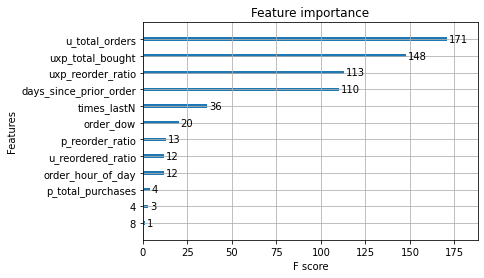

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_val_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

###Проверяем качество на тесте

100%|██████████| 6605/6605 [04:19<00:00, 25.43it/s]




{1: 0.453619803829986, 2: 0.4151331153666511, 3: 0.3840884321968007, 4: 0.3601432352483264, 5: 0.3409606103067017, 6: 0.3248622139187252, 7: 0.31250038922622714, 8: 0.30145248103912264, 9: 0.2915985706130542, 10: 0.2828311203042572}
{1: 0.07950862374554564, 2: 0.13482872870033374, 3: 0.180905302606148, 4: 0.22030628785053202, 5: 0.25496357777277945, 6: 0.28520907318055266, 7: 0.3144739735493034, 8: 0.34100281605281596, 9: 0.36486959546644976, 10: 0.38685329135730223}


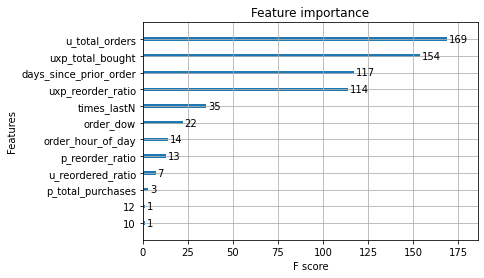

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_test_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

metric_with_lstm_feats = {}

metric_with_lstm_feats[it] = [precision_xgb, recall_xgb]

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/lstm_next_sentence_pred/{0}/metric_with_lstm_feats.pkl'.format(it), 'wb') as f:
  pkl.dump(metric_with_lstm_feats, f)